# Data pre-processing

In [ ]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load the data from the uploaded CSV file
file_path = "/content/combined_mutation_CNV.csv"
data = pd.read_csv(file_path)

# Separate the features and labels
labels = data["Subtype"].values
features = data.drop(columns=["Subtype", "Sample"]).values

# Convert to numpy arrays
labels = np.array(labels)
labels[labels=='PDM'] = 0
labels[labels=='SCM'] = 1

features = np.array(features)

# Output the results
print("Labels:", labels.shape)
print("Features:", features.shape)

Labels: (43,)
Features: (43, 656)


In [ ]:
# Create a MinMaxScaler object with a feature range of -1 to 1
min_max_Scalar = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Fit the MinMaxScaler to the data (excluding the last column) and transform the data
# This scales the features to the specified range (-1 to 1)
features = min_max_Scalar.fit_transform(features)

# Convert the transformed data to a NumPy array
features = np.asarray(features)

# Encode labels if they are not integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Random Forest Feature Importance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Baseline accuracy on test data: 0.67
Accuracy on test data with top 20 features: 0.89


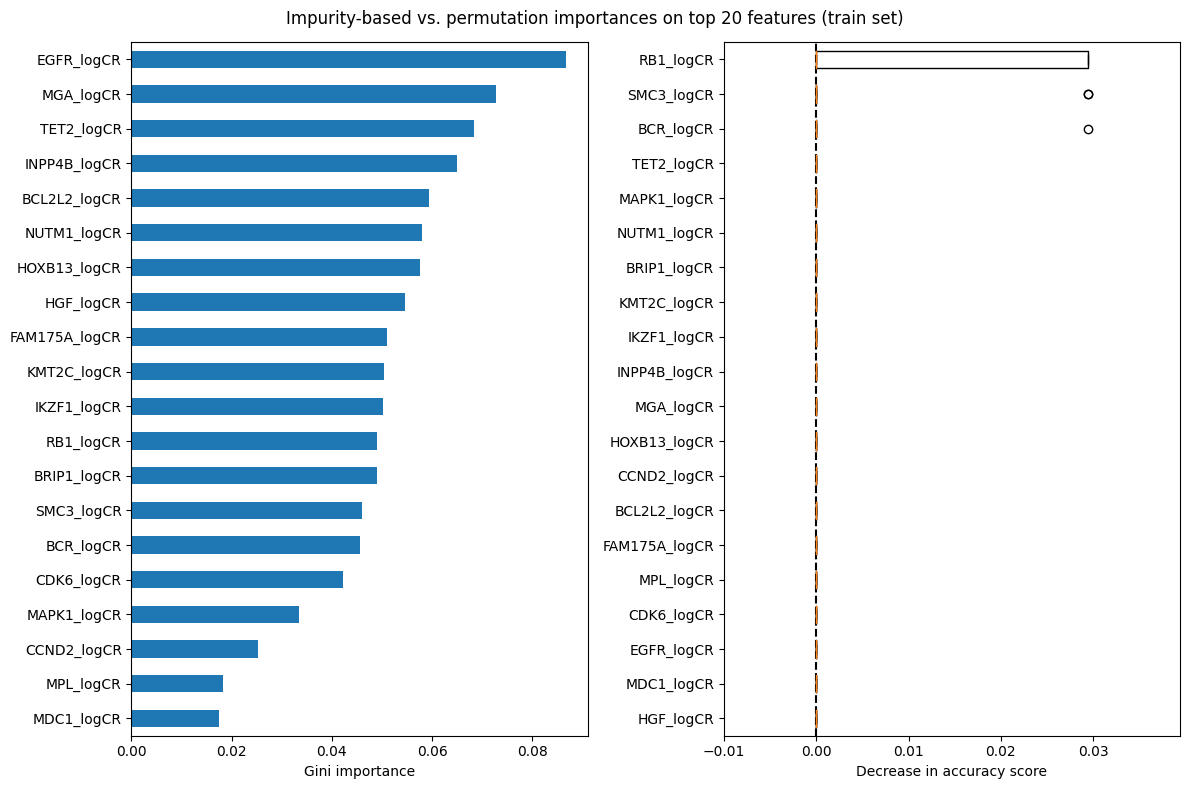

In [ ]:
def plot_top_features(file_path, top_n_features=10):
    # Load the data from the uploaded CSV file
    data = pd.read_csv(file_path)

    # Separate the features and labels
    labels = data["Subtype"].values
    features = data.drop(columns=["Subtype", "Sample"]).values

    # Convert to numpy arrays
    labels = np.array(labels)
    labels[labels == 'PDM'] = 0
    labels[labels == 'SCM'] = 1

    features = np.array(features)

    # Create a MinMaxScaler object with a feature range of -1 to 1
    min_max_Scalar = preprocessing.MinMaxScaler(feature_range=(-1, 1))

    # Fit the MinMaxScaler to the data (excluding the last column) and transform the data
    # This scales the features to the specified range (-1 to 1)
    features = min_max_Scalar.fit_transform(features)

    # Convert the transformed data to a NumPy array
    features = np.asarray(features)

    # Encode labels if they are not integers
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # Split the data
    X, y = features, labels_encoded
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    # Train the RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    print(f"Baseline accuracy on test data: {clf.score(X_test, y_test):.2}")

    # Define the feature names
    feature_names = data.columns[2:]

    # Get the feature importances
    mdi_importances = pd.Series(clf.feature_importances_, index=feature_names)

    # Select the top N features
    top_n_features_names = mdi_importances.nlargest(top_n_features).index
    top_n_indices = [data.columns.get_loc(c) - 2 for c in top_n_features_names]

    X_train_top_n = X_train[:, top_n_indices]
    X_test_top_n = X_test[:, top_n_indices]

    # Retrain the classifier on the top N features
    clf_top_n = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_top_n.fit(X_train_top_n, y_train)
    print(f"Accuracy on test data with top {top_n_features} features: {clf_top_n.score(X_test_top_n, y_test):.2}")

    # Plotting function for permutation importance
    def plot_permutation_importance(clf, X, y, feature_names, ax):
        result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
        perm_sorted_idx = result.importances_mean.argsort()

        ax.boxplot(
            result.importances[perm_sorted_idx].T,
            vert=False,
            labels=feature_names[perm_sorted_idx],
        )
        ax.axvline(x=0, color="k", linestyle="--")

        # Set x-axis range based on the data
        max_importance = result.importances[perm_sorted_idx].max()
        min_importance = result.importances[perm_sorted_idx].min()
        ax.set_xlim(min_importance - 0.01, max_importance + 0.01)

        return ax

    # Plot the feature importances for the top N features
    mdi_importances_top_n = pd.Series(clf_top_n.feature_importances_, index=top_n_features_names)
    tree_importance_sorted_idx = np.argsort(mdi_importances_top_n)
    tree_indices = np.arange(0, len(mdi_importances_top_n)) + 0.5

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    mdi_importances_top_n.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini importance")
    plot_permutation_importance(clf_top_n, X_train_top_n, y_train, top_n_features_names, ax2)
    ax2.set_xlabel("Decrease in accuracy score")
    fig.suptitle(
        f"Impurity-based vs. permutation importances on top {top_n_features} features (train set)"
    )
    _ = fig.tight_layout()

    plt.show()

# Example usage
file_path = "/content/combined_mutation_CNV.csv"
plot_top_features(file_path, top_n_features=20)


# cross-val on process

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

Baseline mean accuracy: 0.46
Mean accuracy with top 20 features: 0.53


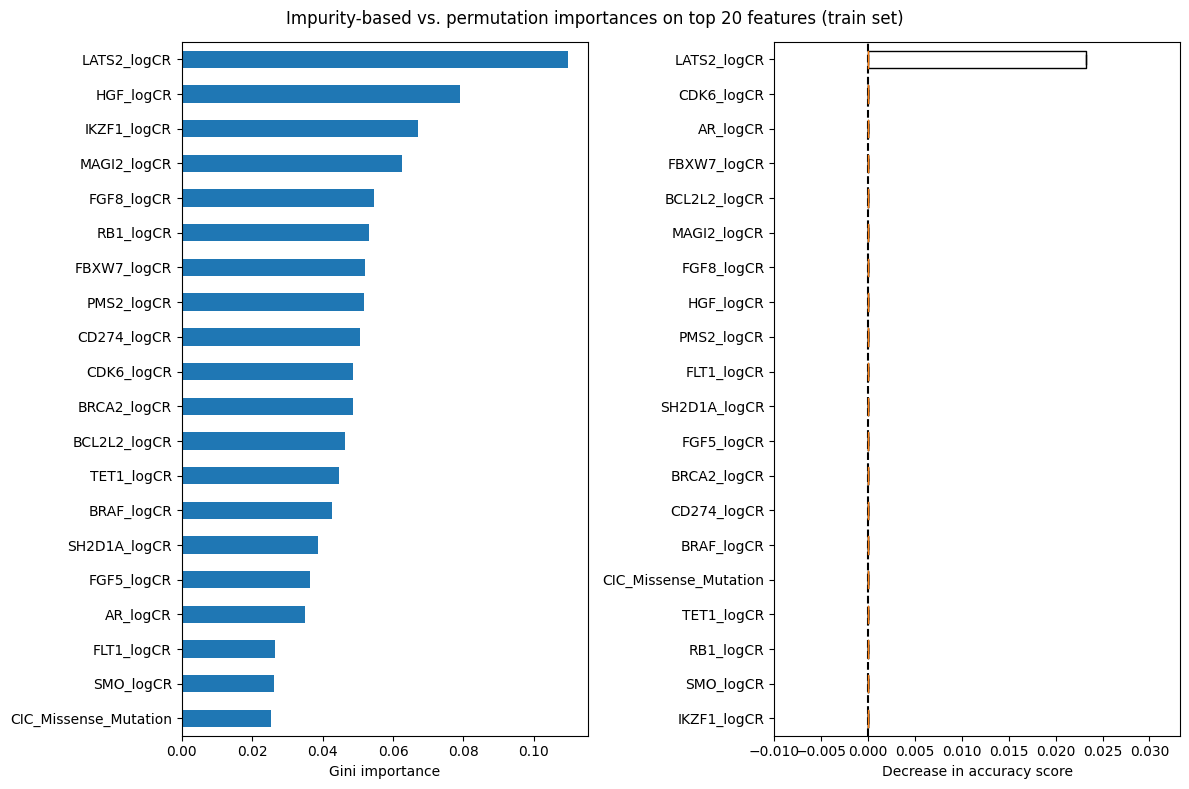

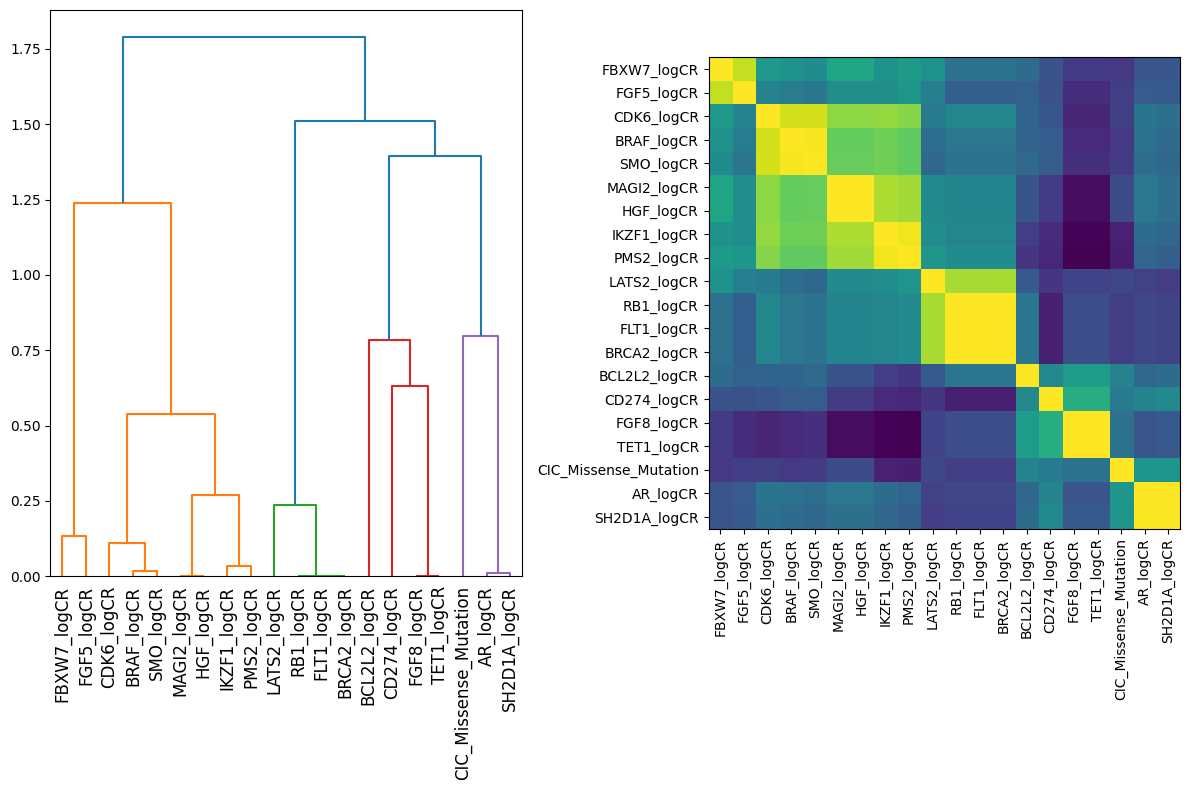

In [ ]:
def plot_top_features(file_path, top_n_features=10, cv=5):
    # Load the data from the uploaded CSV file
    data = pd.read_csv(file_path)

    # Separate the features and labels
    labels = data["Subtype"].values
    features = data.drop(columns=["Subtype", "Sample"]).values

    # Convert to numpy arrays
    labels = np.array(labels)
    labels[labels == 'PDM'] = 0
    labels[labels == 'SCM'] = 1

    features = np.array(features)

    # Create a MinMaxScaler object with a feature range of -1 to 1
    min_max_Scalar = preprocessing.MinMaxScaler(feature_range=(-1, 1)) # 0 1

    # Fit the MinMaxScaler to the data (excluding the last column) and transform the data
    # This scales the features to the specified range (-1 to 1)
    features = min_max_Scalar.fit_transform(features)

    # Convert the transformed data to a NumPy array
    features = np.asarray(features)

    # Encode labels if they are not integers
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # Define the feature names
    feature_names = data.columns[2:]

    # Initialize cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    baseline_scores = []
    top_n_scores = []

    for train_index, test_index in kf.split(features):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels_encoded[train_index], labels_encoded[test_index]

        # Train the RandomForestClassifier for baseline
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        baseline_score = clf.score(X_test, y_test)
        baseline_scores.append(baseline_score)

        # Get the feature importances
        mdi_importances = pd.Series(clf.feature_importances_, index=feature_names)

        # Select the top N features
        top_n_features_names = mdi_importances.nlargest(top_n_features).index
        top_n_indices = [data.columns.get_loc(c) - 2 for c in top_n_features_names]

        X_train_top_n = X_train[:, top_n_indices]
        X_test_top_n = X_test[:, top_n_indices]

        # Retrain the classifier on the top N features
        clf_top_n = RandomForestClassifier(n_estimators=100, random_state=42)
        clf_top_n.fit(X_train_top_n, y_train)
        top_n_score = clf_top_n.score(X_test_top_n, y_test)
        top_n_scores.append(top_n_score)

    print(f"Baseline mean accuracy: {np.mean(baseline_scores):.2f}")
    print(f"Mean accuracy with top {top_n_features} features: {np.mean(top_n_scores):.2f}")

    # Plotting function for permutation importance
    def plot_permutation_importance(clf, X, y, feature_names, ax):
        result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
        perm_sorted_idx = result.importances_mean.argsort()

        ax.boxplot(
            result.importances[perm_sorted_idx].T,
            vert=False,
            labels=feature_names[perm_sorted_idx],
        )
        ax.axvline(x=0, color="k", linestyle="--")

        # Set x-axis range based on the data
        max_importance = result.importances[perm_sorted_idx].max()
        min_importance = result.importances[perm_sorted_idx].min()
        ax.set_xlim(min_importance - 0.01, max_importance + 0.01)

        return ax

    # Fit the classifier on the full data to get feature importances for plotting
    clf.fit(features, labels_encoded)
    mdi_importances = pd.Series(clf.feature_importances_, index=feature_names)
    top_n_features_names = mdi_importances.nlargest(top_n_features).index
    top_n_indices = [data.columns.get_loc(c) - 2 for c in top_n_features_names]
    X_top_n = features[:, top_n_indices]

    clf_top_n.fit(X_top_n, labels_encoded)

    # Plot the feature importances for the top N features
    mdi_importances_top_n = pd.Series(clf_top_n.feature_importances_, index=top_n_features_names)
    tree_importance_sorted_idx = np.argsort(mdi_importances_top_n)
    tree_indices = np.arange(0, len(mdi_importances_top_n)) + 0.5

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    mdi_importances_top_n.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini importance")
    plot_permutation_importance(clf_top_n, X_top_n, labels_encoded, top_n_features_names, ax2)
    ax2.set_xlabel("Decrease in accuracy score")
    fig.suptitle(
        f"Impurity-based vs. permutation importances on top {top_n_features} features (train set)"
    )
    _ = fig.tight_layout()

    plt.show()

    # Plot hierarchical clustering and correlation matrix for top N features
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    corr = spearmanr(X_top_n).correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
        dist_linkage, labels=top_n_features_names.to_list(), ax=ax1, leaf_rotation=90
    )
    dendro_idx = np.arange(0, len(dendro["ivl"]))

    ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    ax2.set_xticks(dendro_idx)
    ax2.set_yticks(dendro_idx)
    ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
    ax2.set_yticklabels(dendro["ivl"])
    _ = fig.tight_layout()

    plt.show()

# Example usage
file_path = "/content/combined_mutation_CNV.csv"
plot_top_features(file_path, top_n_features=20, cv=5) # top features on other models


# analyze_coefficients

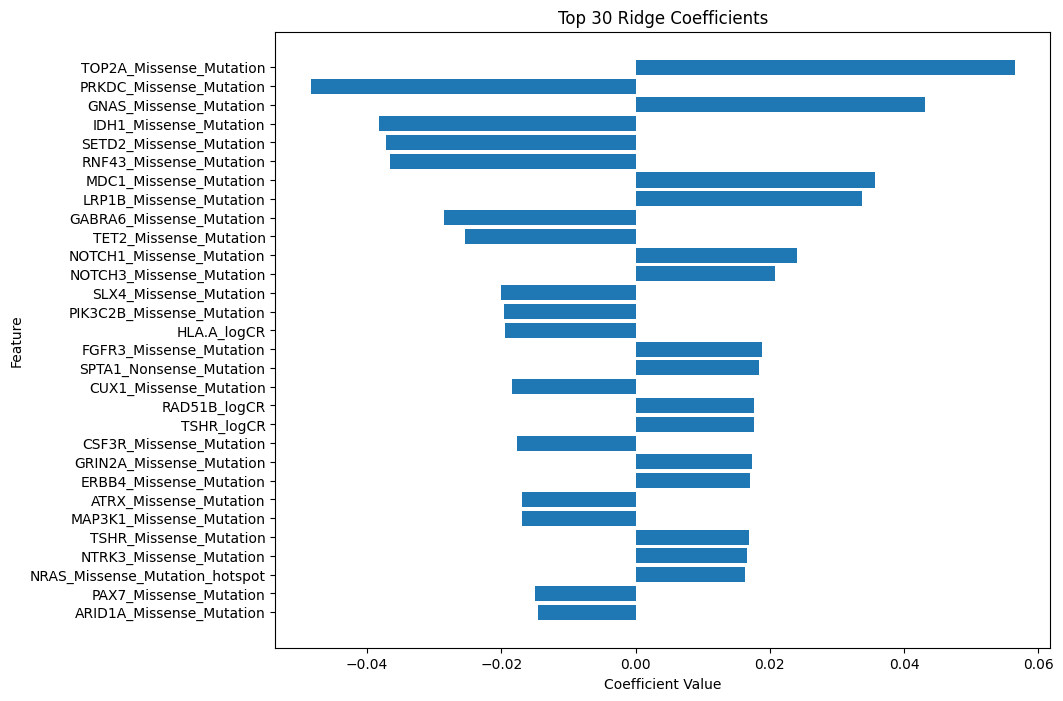

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def analyze_coefficients(data_path, top_n=10):
    """
    Analyze the top N coefficients from a Ridge regression model fitted to the data.

    Parameters:
    data_path (str): Path to the CSV file containing the data.
    top_n (int): Number of top coefficients to analyze. Default is 10.

    Returns:
    pd.DataFrame: DataFrame containing the top N features and their coefficients.
    """
    # Load the data
    data = pd.read_csv(data_path)

    # Preprocess the data
    X = data.drop(columns=['Subtype', 'Sample'])
    y = data['Subtype']

    # Encode the target variable
    y = pd.factorize(y)[0]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit the model
    model = Ridge(random_state=0)
    model.fit(X_train, y_train)

    # Get the coefficients
    coef = model.coef_

    # Get the top N coefficients
    top_n_indices = np.argsort(np.abs(coef))[-top_n:]
    top_n_features = X.columns[top_n_indices]
    top_n_coef = coef[top_n_indices]

    # Plot the top N coefficients
    plt.figure(figsize=(10, 8))
    plt.barh(np.arange(len(top_n_coef)), top_n_coef)
    plt.yticks(np.arange(len(top_n_coef)), top_n_features)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Ridge Coefficients')
    plt.show()

    # Return the top N coefficients for further use if needed
    return pd.DataFrame({'Feature': top_n_features, 'Coefficient': top_n_coef})

# Use the function with the provided data path and number of top features
data_path = '/content/combined_mutation_CNV.csv'
top_n = 30  # You can change this value to get a different number of top features
top_n_coefficients = analyze_coefficients(data_path, top_n)
